# MNIST TUTORIAL

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth" to /root/.cache/torch/hub/checkpoints/mnist-b07bb66b.pth
100%|██████████| 1.03M/1.03M [00:01<00:00, 785kB/s]
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 384MB/s]


### Download the video and load it into EvaDB

In [2]:
# Getting MNIST as a video
!wget -nc "https://www.dropbox.com/s/yxljxz6zxoqu54v/mnist.mp4"

--2023-10-11 05:12:09--  https://www.dropbox.com/s/yxljxz6zxoqu54v/mnist.mp4
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/yxljxz6zxoqu54v/mnist.mp4 [following]
--2023-10-11 05:12:09--  https://www.dropbox.com/s/raw/yxljxz6zxoqu54v/mnist.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5d315012c65bbcab4509062328.dl.dropboxusercontent.com/cd/0/inline/CFb7rISnXkQgn5WYgiiLFS4lmy1CfuXswVdZeVxK2RZIV7iHWjZy12Zzy1_SSEa_c6oIhNa10KmF-zaLyiy7buzqH_qnTS3kvFev0iF5ngZHp9ks1aofg--MU8NL8JUNtac_s3i6I1XJAeeYBBTuMqqi/file# [following]
--2023-10-11 05:12:09--  https://uc5d315012c65bbcab4509062328.dl.dropboxusercontent.com/cd/0/inline/CFb7rISnXkQgn5WYgiiLFS4lmy1CfuXswVdZeVxK2RZIV7iHWjZy12Zzy1_SSEa_c6oIhNa10KmF-zaLyiy7buzqH_qnTS3kvFev0iF5ngZHp9k

In [3]:
# Load the video into EvaDB
cursor.query("DROP TABLE IF EXISTS MNISTVid").df()
cursor.query("LOAD VIDEO 'mnist.mp4' INTO MNISTVid").df()

,0
0,Number of loaded VIDEO: 1


### Run the Image Classification Function over the video

In [4]:
# Run a query on video data
query = cursor.query("""
    SELECT data, MnistImageClassifier(data).label
    FROM MNISTVid
    WHERE id = 30 OR id = 50 OR id = 70 OR id = 0 OR id = 140
""")
response = query.df()

### Visualize output of query on the video

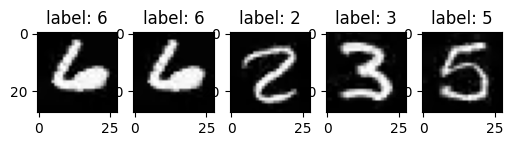

In [5]:
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[6,8])

for axi in ax.flat:
    idx = np.random.randint(len(response))
    img = response['data'].iloc[idx]
    label = response['label'].iloc[idx]
    axi.imshow(img)

    axi.set_title(f'label: {label}')

plt.show()

### Drop the function if needed

In [6]:
cursor.query("DROP FUNCTION MnistImageClassifier").df()

,0
0,Function MnistImageClassifier successfully dro...
